In [1]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

os.makedirs("out1", exist_ok=True)

tensorflow version is 2.1.0
keras version is 2.2.4-tf


In [2]:
def generate_real_data(n_samples=100):
    x = np.random.rand(n_samples) - 0.5
    y = x*x
    data = np.vstack((x, y)).transpose()
    return data

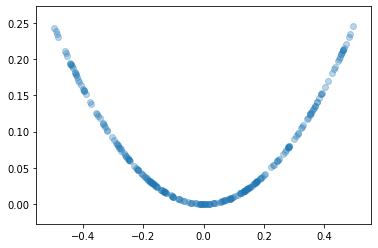

In [3]:
data = generate_real_data(250)
plt.scatter(data[:,0], data[:,1], alpha=0.3)

In [4]:
def make_generator(latent_size=5, hidden_sizes=(15,), activation="relu"):
    model = Sequential()
    for i, h in enumerate(hidden_sizes):
        if i == 0:
            model.add(Dense(h, input_dim=latent_size, activation=activation))
        else:
            model.add(Dense(h, activation=activation))            
    model.add(Dense(2, activation="linear"))
    return model

def make_discriminator(hidden_sizes=(25,), activation="relu"):
    model = Sequential()
    for i, h in enumerate(hidden_sizes):
        if i == 0:
            model.add(Dense(h, input_dim=2, activation=activation))
        else:
            model.add(Dense(h, activation=activation))            
    model.add(Dense(1, activation="sigmoid"))
    return model

def make_gan(generator, discriminator, learning_rate=0.0001):
    discriminator.trainable = True
    discriminator.compile(loss="binary_crossentropy",
                          optimizer=Adam(learning_rate=learning_rate),
                          metrics=["accuracy"])
    
    discriminator.trainable = False
    gan = Sequential([
        generator,
        discriminator
    ])
    gan.compile(loss="binary_crossentropy",
                optimizer=Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
    return gan

In [5]:
def generate_latent(generator, n_samples=100):
    latent_size = generator.input_shape[1]
    x = np.random.randn(n_samples, latent_size)
    return x

def generate_fake_data(generator, n_samples=100):
    x = generate_latent(generator, n_samples)
    y = generator.predict(x)
    return y

In [6]:
def train_gan(generator, discriminator, gan, batchsize=128):
    # update discriminator using real and fake data
    halfbatch = int(batchsize/2)
    real_x = generate_real_data(halfbatch)
    real_y = np.ones((halfbatch, 1))
    fake_x = generate_fake_data(generator, halfbatch)
    fake_y = np.zeros((halfbatch, 1))
    discriminator.train_on_batch(real_x, real_y)
    res_d = discriminator.train_on_batch(fake_x, fake_y)
    
    # update generator using fake data
    gan_x = generate_latent(generator, batchsize)
    gan_y = np.ones((batchsize, 1))
    res_g = gan.train_on_batch(gan_x, gan_y)
    return res_d, res_g

def eval_gan(generator, discriminator, iteration, name="", batchsize=250, keepfig=False, savefig=True):
    print("")
    real_x = generate_real_data(batchsize)
    real_y = np.ones((batchsize, 1))
    real_res = discriminator.evaluate(real_x, real_y, verbose=0)
    
    fake_x = generate_fake_data(generator, batchsize)
    fake_y = np.zeros((batchsize, 1))
    fake_res = discriminator.evaluate(fake_x, fake_y, verbose=0)
    print("Iter %d: true positive rate = %.3f, true negative rate = %.3f" % (
        iteration, real_res[1], fake_res[1]))
    fig, ax = plt.subplots()
    ax.scatter(real_x[:,0], real_x[:,1], alpha=0.3, color="blue", label="real")
    ax.scatter(fake_x[:,0], fake_x[:,1], alpha=0.3, color="red", label="fake")
    if savefig:
        fig.savefig("out1/%s_%07d.png" % (name, iteration))
    if not keepfig:
        plt.close(fig)
    return None

In [7]:
generator = make_generator()
discriminator = make_discriminator()
gan = make_gan(generator, discriminator)

print("* generator *")
generator.summary()
print("\n* discriminator *")
discriminator.summary()
print("\n* GAN *")
gan.summary()

* generator *
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________

* discriminator *
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 202
Trainable params: 101
Non-trainable params: 101
_________________________________________________________________

* 

In [8]:
generator = make_generator()
discriminator = make_discriminator()
gan = make_gan(generator, discriminator)

eval_gan(generator, discriminator, 0, name="square") 
for i in range(15000):
    res_d, res_g = train_gan(generator, discriminator, gan, batchsize=128)
    print("\rIter %6d. loss = (%.3f, %.3f), acc = (%.3f, %.3f)" % (
        i+1, res_d[0], res_g[0], res_d[1], res_g[1]), end="")
    if (i+1) % 1000 == 0:
        eval_gan(generator, discriminator, i+1, name="square")          


Iter 0: true positive rate = 1.000, true negative rate = 0.120
Iter   1000. loss = (0.681, 0.703), acc = (0.578, 0.414)
Iter 1000: true positive rate = 0.668, true negative rate = 0.636
Iter   2000. loss = (0.708, 0.679), acc = (0.234, 0.750)
Iter 2000: true positive rate = 0.716, true negative rate = 0.256
Iter   3000. loss = (0.708, 0.680), acc = (0.047, 0.945)
Iter 3000: true positive rate = 1.000, true negative rate = 0.052
Iter   4000. loss = (0.700, 0.686), acc = (0.266, 0.797)
Iter 4000: true positive rate = 1.000, true negative rate = 0.188
Iter   5000. loss = (0.697, 0.687), acc = (0.297, 0.812)
Iter 5000: true positive rate = 0.952, true negative rate = 0.220
Iter   6000. loss = (0.696, 0.690), acc = (0.266, 0.703)
Iter 6000: true positive rate = 0.848, true negative rate = 0.304
Iter   7000. loss = (0.697, 0.692), acc = (0.250, 0.648)
Iter 7000: true positive rate = 0.776, true negative rate = 0.412
Iter   8000. loss = (0.695, 0.692), acc = (0.281, 0.656)
Iter 8000: true po


Iter 15000: true positive rate = 0.696, true negative rate = 0.420


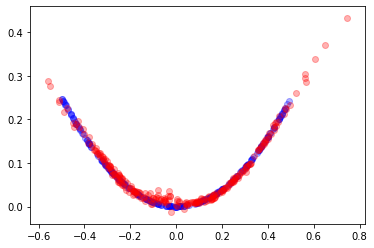

In [9]:
eval_gan(generator, discriminator, i+1, name="square", savefig=False, keepfig=True)

In [10]:
generator.save("out1/square-generator_%07d.h5" % (i+1))
discriminator.save("out1/square-discriminator_%07d.h5" % (i+1))

In [11]:
def generate_real_data(n_samples=100):
    x = np.random.random(n_samples) - 0.5
    y = np.sin((x+0.5)*6.24)
    data = np.vstack((x, y)).transpose()
    return data

generator = make_generator(latent_size=5, hidden_sizes=(16, 16))
discriminator = make_discriminator(hidden_sizes=(32, 16))
gan = make_gan(generator, discriminator)

eval_gan(generator, discriminator, 0, name="sin") 
for i in range(30000):
    res_d, res_g = train_gan(generator, discriminator, gan, batchsize=128)
    print("\rIter %6d. loss = (%.3f, %.3f), acc = (%.3f, %.3f)" % (
        i+1, res_d[0], res_g[0], res_d[1], res_g[1]), end="")
    if (i+1) % 1000 == 0:
        eval_gan(generator, discriminator, i+1, name="sin") 


Iter 0: true positive rate = 0.976, true negative rate = 0.032
Iter   1000. loss = (0.649, 0.741), acc = (0.859, 0.188)
Iter 1000: true positive rate = 0.448, true negative rate = 0.760
Iter   2000. loss = (0.643, 0.753), acc = (1.000, 0.000)
Iter 2000: true positive rate = 0.000, true negative rate = 1.000
Iter   3000. loss = (0.683, 0.704), acc = (0.422, 0.617)
Iter 3000: true positive rate = 0.804, true negative rate = 0.408
Iter   4000. loss = (0.660, 0.721), acc = (0.891, 0.102)
Iter 4000: true positive rate = 0.484, true negative rate = 0.876
Iter   5000. loss = (0.660, 0.723), acc = (0.906, 0.242)
Iter 5000: true positive rate = 0.444, true negative rate = 0.792
Iter   6000. loss = (0.668, 0.717), acc = (0.688, 0.367)
Iter 6000: true positive rate = 0.624, true negative rate = 0.640
Iter   7000. loss = (0.680, 0.712), acc = (0.562, 0.398)
Iter 7000: true positive rate = 0.572, true negative rate = 0.628
Iter   8000. loss = (0.682, 0.704), acc = (0.578, 0.422)
Iter 8000: true po


Iter 30000: true positive rate = 0.280, true negative rate = 0.676


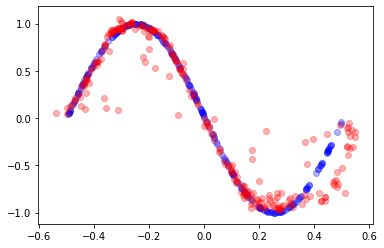

In [12]:
eval_gan(generator, discriminator, i+1, name="square", savefig=False, keepfig=True)

In [13]:
generator.save("out1/sin-generator_%07d.h5" % (i+1))
discriminator.save("out1/sin-discriminator_%07d.h5" % (i+1))

In [14]:
def generate_real_data(n_samples=100):
    theta = np.random.random(n_samples) * np.pi * 2
    x = np.cos(theta)
    y = np.sin(theta)
    data = np.vstack((x, y)).transpose()
    return data

generator = make_generator(latent_size=5, hidden_sizes=(16,16))
discriminator = make_discriminator(hidden_sizes=(32,16))
gan = make_gan(generator, discriminator)

eval_gan(generator, discriminator, 0, name="circle") 
for i in range(20000):
    res_d, res_g = train_gan(generator, discriminator, gan, batchsize=128)
    print("\rIter %6d. loss = (%.3f, %.3f), acc = (%.3f, %.3f)" % (
        i+1, res_d[0], res_g[0], res_d[1], res_g[1]), end="")
    if (i+1) % 1000 == 0:
        eval_gan(generator, discriminator, i+1, name="circle") 


Iter 0: true positive rate = 0.644, true negative rate = 0.960
Iter   1000. loss = (0.643, 0.748), acc = (0.906, 0.117)
Iter 1000: true positive rate = 0.580, true negative rate = 0.848
Iter   2000. loss = (0.864, 0.549), acc = (0.250, 0.766)
Iter 2000: true positive rate = 0.544, true negative rate = 0.232
Iter   3000. loss = (0.694, 0.701), acc = (0.469, 0.484)
Iter 3000: true positive rate = 0.256, true negative rate = 0.528
Iter   4000. loss = (0.657, 0.719), acc = (0.750, 0.359)
Iter 4000: true positive rate = 0.412, true negative rate = 0.704
Iter   5000. loss = (0.658, 0.736), acc = (0.594, 0.367)
Iter 5000: true positive rate = 0.584, true negative rate = 0.568
Iter   6000. loss = (0.683, 0.706), acc = (0.703, 0.328)
Iter 6000: true positive rate = 0.336, true negative rate = 0.752
Iter   7000. loss = (0.675, 0.713), acc = (0.750, 0.242)
Iter 7000: true positive rate = 0.472, true negative rate = 0.792
Iter   8000. loss = (0.680, 0.704), acc = (0.734, 0.375)
Iter 8000: true po


Iter 20000: true positive rate = 0.632, true negative rate = 0.488


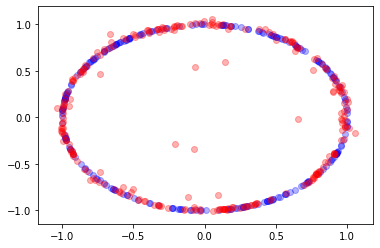

In [15]:
eval_gan(generator, discriminator, i+1, name="circle", savefig=False, keepfig=True)

In [16]:
generator.save("out1/circle-generator_%07d.h5" % (i+1))
discriminator.save("out1/circle-discriminator_%07d.h5" % (i+1))